In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer, SimpleImputer
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

In [31]:
dataset = pd.read_csv("CreditPrediction.csv")
dataset

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 19
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061,NaN
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105,NaN
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000,NaN
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,NaN
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10162,718673358,35.0,M,3,Doctorate,NaN,$80K - $120K,Blue,30.0,5.0,3,4,13590.0,1528,0.728,2137,52,0.486,0.112,NaN
10163,715207458,46.0,F,1,Unknown,Single,Less than $40K,Blue,39.0,2.0,2,1,2029.0,1074,0.514,4802,90,0.800,0.529,NaN
10164,803665983,52.0,M,0,Unknown,NaN,$60K - $80K,Blue,46.0,3.0,2,4,2742.0,2184,0.592,3829,72,0.532,0.796,NaN
10165,713183508,39.0,F,1,High School,NaN,Unknown,NaN,36.0,1.0,3,2,2751.0,1158,0.821,4861,82,0.822,0.421,NaN


In [32]:
dataset = dataset.drop_duplicates(subset=['CLIENTNUM'])
print("Shape After: ", dataset.shape)

Shape After:  (10127, 20)


In [33]:
dataset = dataset.drop(['Unnamed: 19', 'Total_Ct_Chng_Q4_Q1', 'CLIENTNUM', 'Education_Level', 'Months_on_book','Marital_Status'], 
                       axis=1)

In [34]:
# dataset['Card_Category'] = dataset['Card_Category'].fillna(dataset['Card_Category'].mode()[0])
# dataset['Total_Relationship_Count'] = dataset['Total_Relationship_Count'].fillna(dataset['Total_Relationship_Count'].mean())

In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              10127 non-null  float64
 1   Gender                    9928 non-null   object 
 2   Dependent_count           10127 non-null  int64  
 3   Income_Category           10127 non-null  object 
 4   Card_Category             8214 non-null   object 
 5   Total_Relationship_Count  10107 non-null  float64
 6   Months_Inactive_12_mon    10127 non-null  int64  
 7   Contacts_Count_12_mon     10127 non-null  int64  
 8   Credit_Limit              10127 non-null  float64
 9   Total_Revolving_Bal       10127 non-null  int64  
 10  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 11  Total_Trans_Amt           10127 non-null  int64  
 12  Total_Trans_Ct            10127 non-null  int64  
 13  Avg_Utilization_Ratio     10127 non-null  float64
dtypes: float64(

In [36]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

In [37]:
z_dataset = pd.DataFrame()

In [38]:
# z_dataset['Customer_Age'] = np.abs(stats.zscore(dataset['Customer_Age']))
# outlAge = list(np.where(np.abs(z_dataset['Customer_Age']) > 3)[0])
# print("Age Outliers: ", outlAge)
# print("Total outlier Age: ", len(outlAge), "\n")
# dataset.iloc[outlAge, :]

In [39]:
# dataset = dataset.drop(dataset.index[outlAge])
# dataset.shape

In [40]:
# for i in outlAge:
#     dataset.replace(dataset.iloc[i]['Customer_Age'], dataset['Customer_Age'].mean(), inplace=True)

In [41]:
z_dataset['Total_Trans_Amt'] = np.abs(stats.zscore(dataset['Total_Trans_Amt']))
outlAmt = list(np.where(np.abs(z_dataset['Total_Trans_Amt']) > 3)[0])
# print("Total_Trans_Amt Outliers: ", outlAmt)
# print("Total outlier Total_Trans_Amt: ", len(outlAmt), "\n")
# dataset.iloc[outlAmt, :]

In [42]:
dataset = dataset.drop(dataset.index[outlAmt])
dataset.shape

(9736, 14)

In [43]:
z_dataset['Total_Trans_Ct'] = np.abs(stats.zscore(dataset['Total_Trans_Ct']))
outlct = list(np.where(np.abs(z_dataset['Total_Trans_Ct']) > 3)[0])
# print("Total_Trans_Ct Outliers: ", outlct)
# print("Total outlier Total_Trans_Ct: ", len(outlct), "\n")
# dataset.iloc[outlct, :]

In [44]:
dataset = dataset.drop(dataset.index[outlct])
dataset.shape

(9727, 14)

In [45]:
missing_values = ["NaN", "Unknown", ""]
dataset.replace(missing_values, np.nan, inplace=True)

In [46]:

# for feature in categorical_features:
#     dataset[feature] = dataset[feature].astype(str)

dataset['Income_Category'] = dataset['Income_Category'].map({"Less than $40K":0, "$40K - $60K":1, "$60K - $80K":2 ,"$80K - $120K":3, "$120K +":4})
dataset['Card_Category'] = dataset['Card_Category'].map({"Blue":0, "Silver":1, "Gold":2, "Platinum":3})
dataset['Gender'] = dataset['Gender'].map({"M":0, "F":1})

In [47]:
# dataset['Income_Category'] = LabelEncoder().fit_transform(dataset['Income_Category'])
# dataset['Card_Category'] = LabelEncoder().fit_transform(dataset['Card_Category'])

In [48]:
# dataset['Card_Category'] = dataset['Card_Category'].fillna(dataset['Card_Category'].mode()[0])
# dataset['Total_Relationship_Count'] = dataset['Total_Relationship_Count'].fillna(dataset['Total_Relationship_Count'].mean())

In [49]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# مرحله 2: مقداردهی اولیه داده‌های مفقود با میانگین
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(dataset)

# تبدیل داده‌های پر شده به DataFrame
df_imputed = pd.DataFrame(data_imputed, columns=dataset.columns)

# نمایش داده‌های پر شده با میانگین


# مرحله 3: اجرای الگوریتم K-means
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(data_imputed)

# اضافه کردن برچسب خوشه به داده‌ها
df_imputed['cluster'] = clusters



# مرحله 4: جایگزینی داده‌های مفقود
for feature in dataset.columns:
    if dataset[feature].isnull().any():
        for cluster in range(kmeans.n_clusters):
            # محاسبه میانگین ویژگی برای هر خوشه
            cluster_mean = df_imputed[df_imputed['cluster'] == cluster][feature].mean()
            # جایگزینی داده‌های مفقود با میانگین خوشه
            df_imputed.loc[(df_imputed['cluster'] == cluster) & (dataset[feature].isnull()), feature] = cluster_mean

# حذف ستون برچسب خوشه
df_final = df_imputed.drop(columns=['cluster'])

# نمایش داده‌های نها

df = df_final
df_imputed

C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Customer_Age,Gender,Dependent_count,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio,cluster
0,45.0,0.0,3.0,2.000000,0.000000,5.0,1.0,3.0,12691.0,777.0,1.335,1144.0,42.0,0.061,2
1,49.0,1.0,5.0,0.000000,0.000000,6.0,1.0,2.0,8256.0,864.0,1.541,1291.0,33.0,0.105,6
2,51.0,0.0,3.0,3.000000,0.000000,4.0,1.0,0.0,3418.0,0.0,2.594,1887.0,20.0,0.000,0
3,40.0,1.0,4.0,0.000000,0.000000,3.0,4.0,1.0,3313.0,2517.0,1.405,1171.0,20.0,0.760,0
4,40.0,0.0,3.0,2.000000,0.014725,5.0,1.0,0.0,4716.0,0.0,2.175,816.0,28.0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9722,55.0,1.0,3.0,1.332447,0.000000,4.0,3.0,3.0,14657.0,2517.0,0.166,6009.0,53.0,0.172,8
9723,41.0,0.0,2.0,1.000000,0.000000,4.0,2.0,3.0,4277.0,2186.0,0.804,8764.0,69.0,0.511,4
9724,44.0,1.0,1.0,0.000000,0.032381,5.0,3.0,4.0,5409.0,0.0,0.819,10291.0,60.0,0.000,4
9725,30.0,0.0,2.0,1.000000,0.000000,4.0,3.0,3.0,5281.0,0.0,0.535,8395.0,62.0,0.000,4


In [50]:
from scipy import stats

# Box-Cox transformation
box_cox_transformed, _ = stats.boxcox(dataset['Customer_Age'])
dataset['Customer_Age'] = box_cox_transformed

box_cox_transformed, _ = stats.boxcox(dataset['Total_Trans_Amt'])
dataset['Total_Trans_Amt'] = box_cox_transformed

dataset

,Customer_Age,Gender,Dependent_count,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio
0,1.864570,0.0,3,2.0,0.0,5.0,1,3,12691.0,777,1.335,6.531727,42,0.061
1,1.880640,1.0,5,0.0,0.0,6.0,1,2,8256.0,864,1.541,6.635384,33,0.105
2,1.887987,0.0,3,3.0,0.0,4.0,1,0,3418.0,0,2.594,6.959098,20,0.000
3,1.841343,1.0,4,0.0,0.0,3.0,4,1,3313.0,2517,1.405,6.551751,20,0.760
4,1.841343,0.0,3,2.0,NaN,5.0,1,0,4716.0,0,2.175,6.240569,28,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10119,1.901512,1.0,3,NaN,0.0,4.0,3,3,14657.0,2517,0.166,7.930633,53,0.172
10123,1.846311,0.0,2,1.0,0.0,4.0,2,3,4277.0,2186,0.804,8.241958,69,0.511
10124,1.860229,1.0,1,0.0,0.0,5.0,3,4,5409.0,0,0.819,8.373687,60,0.000
10125,1.779371,0.0,2,1.0,0.0,4.0,3,3,5281.0,0,0.535,8.206601,62,0.000


In [51]:
features = df.columns.difference(['Credit_Limit'])  # All columns except 'SalePrice'
target = 'Credit_Limit'

categorical_features = df[features].select_dtypes(include=['object']).columns

for feature in categorical_features:

    df[feature] = df[feature].astype(str)
 

In [52]:
X = dataset[features]
# StandardScaler
scaler = MinMaxScaler()

# Fit the scaler to the features and transform them
X_scaled = scaler.fit_transform(X)



y = dataset[target]

# pca = PCA(n_components=4)
# X = pca.fit_transform(X)

# X = SelectKBest(f_classif, k=8).fit_transform(X, y)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_features_indices = np.where(X.dtypes == 'object')[0]

In [54]:
# Check for missing values

missing_values = dataset.isnull().sum().sort_values(ascending=False)

missing_values = missing_values[missing_values > 0]

print("\nColumns with missing values:\n", missing_values)


Columns with missing values:
 Card_Category               1839
Income_Category             1082
Gender                       195
Total_Relationship_Count      19
dtype: int64


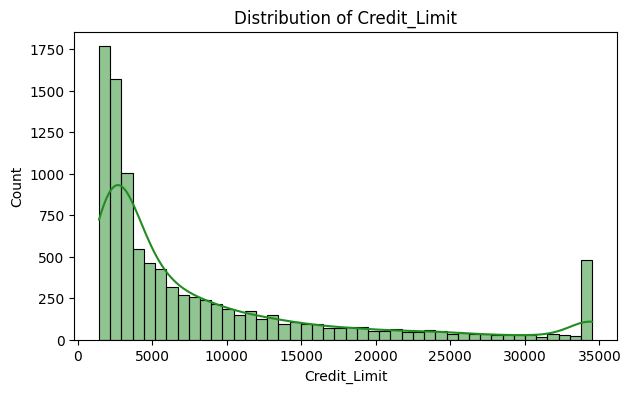

In [55]:
plt.figure(figsize=(7, 4))

sns.histplot(dataset['Credit_Limit'], kde=True, color='forestgreen')

plt.title('Distribution of Credit_Limit')
plt.show()

In [56]:
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train, y_train)

y_pred = lgb_reg.predict(X_test)
print(mean_squared_error(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 7781, number of used features: 13
[LightGBM] [Info] Start training from score 8464.589978
7828478.407732631


In [28]:
# Create CatBoost pools for training and testing

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)

test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)
 
# Train the CatBoost model

model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.1,
    eval_metric='RMSE',
    logging_level='Verbose',  # Can be 'Silent' to reduce output
    use_best_model=True, nan_mode='Max'
)

# Train the model with evaluation
model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=50  # Stops if validation RMSE doesn't improve for 50 rounds
)

0:	learn: 8366.3571707	test: 8146.6523583	best: 8146.6523583 (0)	total: 151ms	remaining: 25m 10s
1:	learn: 7850.9788958	test: 7642.9226639	best: 7642.9226639 (1)	total: 155ms	remaining: 12m 52s
2:	learn: 7397.5159245	test: 7200.9247839	best: 7200.9247839 (2)	total: 158ms	remaining: 8m 45s
3:	learn: 6958.1915545	test: 6777.4428782	best: 6777.4428782 (3)	total: 161ms	remaining: 6m 41s
4:	learn: 6578.5428283	test: 6418.2437795	best: 6418.2437795 (4)	total: 164ms	remaining: 5m 27s
5:	learn: 6260.3857935	test: 6115.9203472	best: 6115.9203472 (5)	total: 167ms	remaining: 4m 37s
6:	learn: 5946.2953461	test: 5806.4848285	best: 5806.4848285 (6)	total: 170ms	remaining: 4m 2s
7:	learn: 5693.6551387	test: 5583.0210837	best: 5583.0210837 (7)	total: 173ms	remaining: 3m 35s
8:	learn: 5469.3524020	test: 5368.3837690	best: 5368.3837690 (8)	total: 176ms	remaining: 3m 15s
9:	learn: 5219.1002816	test: 5110.2160435	best: 5110.2160435 (9)	total: 179ms	remaining: 2m 58s
10:	learn: 5021.8469619	test: 4901.1917

In [29]:
# Make predictions on the test set
y_pred = model.predict(test_pool)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
 
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean squared Error (MSE): {mse:.2f}')
print(f'R2 Score: {r2:.4f}')

Mean Absolute Error (MAE): 1232.18
Mean squared Error (MSE): 7689266.26
R2 Score: 0.8997
